Correct the log distance ratios for the size-limited selection of the SGA.  This follows the method outlined in [Springob et al. (2015)](https://ui.adsabs.harvard.edu/abs/2016MNRAS.456.1886S/abstract).

In [1]:
import numpy as np

from scipy.special import gammaln
from scipy.optimize import minimize

import emcee

from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import Distance
from astropy.cosmology import Planck18, LambdaCDM
from astropy import units as u

from corner import corner

import matplotlib.pyplot as plt

# Import data

## Y1 data

In [2]:
filename = 'SGA_iron_jointTFR-varyV0-perpdwarf-fitH0_zCMB0p1_moduli.fits'

hdul = fits.open(filename)
SGA_TF = Table(hdul[1].data)
hdr = hdul[0].header
hdul.close()

H0 = hdr['H0']

SGA_TF[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT,Z_DESI,ZERR_DESI,V_0p4R26,V_0p4R26_ERR,PHOTSYS,Z_DESI_CMB,G_MAG_SB26_CORR,R_MAG_SB26_CORR,Z_MAG_SB26_CORR,G_MAG_SB26_ERR_CORR,R_MAG_SB26_ERR_CORR,Z_MAG_SB26_ERR_CORR,MU_ZCMB,R_ABSMAG_SB26,MU_ZCMB_ERR,R_ABSMAG_SB26_ERR,DWARF,R_ABSMAG_SB26_TF,R_ABSMAG_SB26_TF_ERR,R_ABSMAG_SB26_TF_ERR_STAT,R_ABSMAG_SB26_TF_ERR_SYS,MU_TF,MU_TF_ERR,LOGDIST,LOGDIST_ERR
int64,str16,str29,int64,float64,float64,str21,float32,float32,float32,float32,float32,float32,bool,str13,int64,str35,int16,bool,float64,float64,float32,str8,float64,float64,float32,str4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32,float64,float64,float64,float64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64
38,SGA-2020 38,SDSSJ140638.88+393138.1,3558705,211.66194,39.5272341,S?,81.63,0.35318315,0.37757218,0.08108376,24.72948,18.361,False,LEDA-20181114,12,SDSSJ140638.88+393138.1,1,True,211.66194,39.5272341,0.35318315,2115p395,211.66203166014844,39.52724032794356,0.41757938,SB26,82.21093,0.41431504,211.6619547015994,39.52729608884245,8.520181,5.252184,4.0750155,3.3951538,3.3006833,4.4037066,5.5453897,6.693271,7.8023033,8.999919,10.213078,11.41192,12.527382,19.246052,18.406073,17.931826,18.841032,18.092857,17.659027,18.566164,17.886087,17.47688,18.383362,17.749825,17.355968,18.261652,17.655558,17.284552,18.168955,17.588947,17.231817,18.101948,17.547142,17.20673,18.055267,17.516266,17.18719,18.023865,17.497095,17.178627,0.041267984,0.058114093,0.082968995,0.08808186,0.099526815,0.11876543,0.11355961,0.14645264,0.17035669,0.028041152,0.045385383,0.052895926,0.02822557,0.041093465,0.04698563,0.027371243,0.038240846,0.043213904,0.026219657,0.03618844,0.04070005

## SGA catalog

In [3]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

SGA[:5]

SGA_ID,SGA_GALAXY,GALAXY,PGC,RA_LEDA,DEC_LEDA,MORPHTYPE,PA_LEDA,D25_LEDA,BA_LEDA,Z_LEDA,SB_D25_LEDA,MAG_LEDA,BYHAND,REF,GROUP_ID,GROUP_NAME,GROUP_MULT,GROUP_PRIMARY,GROUP_RA,GROUP_DEC,GROUP_DIAMETER,BRICKNAME,RA,DEC,D26,D26_REF,PA,BA,RA_MOMENT,DEC_MOMENT,SMA_MOMENT,G_SMA50,R_SMA50,Z_SMA50,SMA_SB22,SMA_SB22.5,SMA_SB23,SMA_SB23.5,SMA_SB24,SMA_SB24.5,SMA_SB25,SMA_SB25.5,SMA_SB26,G_MAG_SB22,R_MAG_SB22,Z_MAG_SB22,G_MAG_SB22.5,R_MAG_SB22.5,Z_MAG_SB22.5,G_MAG_SB23,R_MAG_SB23,Z_MAG_SB23,G_MAG_SB23.5,R_MAG_SB23.5,Z_MAG_SB23.5,G_MAG_SB24,R_MAG_SB24,Z_MAG_SB24,G_MAG_SB24.5,R_MAG_SB24.5,Z_MAG_SB24.5,G_MAG_SB25,R_MAG_SB25,Z_MAG_SB25,G_MAG_SB25.5,R_MAG_SB25.5,Z_MAG_SB25.5,G_MAG_SB26,R_MAG_SB26,Z_MAG_SB26,SMA_SB22_ERR,SMA_SB22.5_ERR,SMA_SB23_ERR,SMA_SB23.5_ERR,SMA_SB24_ERR,SMA_SB24.5_ERR,SMA_SB25_ERR,SMA_SB25.5_ERR,SMA_SB26_ERR,G_MAG_SB22_ERR,R_MAG_SB22_ERR,Z_MAG_SB22_ERR,G_MAG_SB22.5_ERR,R_MAG_SB22.5_ERR,Z_MAG_SB22.5_ERR,G_MAG_SB23_ERR,R_MAG_SB23_ERR,Z_MAG_SB23_ERR,G_MAG_SB23.5_ERR,R_MAG_SB23.5_ERR,Z_MAG_SB23.5_ERR,G_MAG_SB24_ERR,R_MAG_SB24_ERR,Z_MAG_SB24_ERR,G_MAG_SB24.5_ERR,R_MAG_SB24.5_ERR,Z_MAG_SB24.5_ERR,G_MAG_SB25_ERR,R_MAG_SB25_ERR,Z_MAG_SB25_ERR,G_MAG_SB25.5_ERR,R_MAG_SB25.5_ERR,Z_MAG_SB25.5_ERR,G_MAG_SB26_ERR,R_MAG_SB26_ERR,Z_MAG_SB26_ERR,G_COG_PARAMS_MTOT,G_COG_PARAMS_M0,G_COG_PARAMS_ALPHA1,G_COG_PARAMS_ALPHA2,G_COG_PARAMS_CHI2,R_COG_PARAMS_MTOT,R_COG_PARAMS_M0,R_COG_PARAMS_ALPHA1,R_COG_PARAMS_ALPHA2,R_COG_PARAMS_CHI2,Z_COG_PARAMS_MTOT,Z_COG_PARAMS_M0,Z_COG_PARAMS_ALPHA1,Z_COG_PARAMS_ALPHA2,Z_COG_PARAMS_CHI2,ELLIPSEBIT
int64,bytes16,bytes29,int64,float64,float64,bytes21,float32,float32,float32,float32,float32,float32,bool,bytes13,int64,bytes35,int16,bool,float64,float64,float32,bytes8,float64,float64,float32,bytes4,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int32
2,SGA-2020 2,PGC1283207,1283207,228.3770865,5.4232017,S?,152.2,0.36307806,0.724436,0.03463229,23.40448,16.976,False,LEDA-20181114,0,PGC1283207,1,True,228.3770865,5.4232017,0.36307806,2283p055,228.3770803831908,5.423191398593787,0.49470574,SB26,158.20142,0.545691,228.37700918822188,5.4232652570544015,10.897086,3.3509698,3.1147978,3.240862,5.902337,6.9126143,7.941369,8.997992,10.073601,11.199986,12.391357,13.561038,14.841172,16.966799,16.108246,15.486356,16.879545,16.024958,15.400715,16.818878,15.967034,15.341793,16.776297,15.925804,15.300776,16.746685,15.897334,15.272053,16.725166,15.876816,15.2521105,16.708357,15.862035,15.237181,16.696539,15.851936,15.226998,16.689613,15.844313,15.21976,0.013392451,0.02354,0.021872982,0.01736985,0.024445537,0.039866067,0.05026544,0.08455789,0.122911856,0.005682776,0.0054258136,0.0049038026,0.005588406,0.005323561,0.0047632363,0.00543534,0.005177031,0.0046343105,0.0053025587,0.005040888,0.0045181247,0.005206092,0.0049438984,0.0044374703,0.0051483097,0.0048758644,0.0043834248,0.0051032505,0.0048264163,0.004344248,0.0050705094,0.004792021,0.004319857,0.005054293,0.004765629,0.0043044444,16.65942,0.34037337,0.2978292,3.0239506,0.07928849,15.820566,0.2640441,0.34559453,3.3033552,0.003811298,15.195567,0.29826432,0.3001073,3.2333765,0.011723555,0
3,SGA-2020 3,PGC1310416,1310416,202.54443750000002,6.9345944,Sc,159.26,0.4017908,0.7816278,0.073888786,23.498482,16.85,False,LEDA-20181114,1,PGC1310416,1,True,202.54443750000002,6.9345944,0.4017908,

## NSA

In [4]:
NSA = Table.read('/global/cfs/projectdirs/sdss/data/sdss/dr17/sdss/atlas/v1/nsa_v1_0_1.fits')

NSA[:5]

IAUNAME,SUBDIR,RA,DEC,ISDSS,INED,ISIXDF,IALFALFA,IZCAT,ITWODF,MAG,Z,ZSRC,SIZE,RUN,CAMCOL,FIELD,RERUN,XPOS,YPOS,NSAID,ZDIST,SERSIC_NMGY,SERSIC_NMGY_IVAR,SERSIC_OK,SERSIC_RNMGY,SERSIC_ABSMAG,SERSIC_AMIVAR,EXTINCTION,SERSIC_KCORRECT,SERSIC_KCOEFF,SERSIC_MTOL,SERSIC_B300,SERSIC_B1000,SERSIC_METS,SERSIC_MASS,XCEN,YCEN,NPROF,PROFMEAN,PROFMEAN_IVAR,QSTOKES,USTOKES,BASTOKES,PHISTOKES,PETRO_FLUX,PETRO_FLUX_IVAR,FIBER_FLUX,FIBER_FLUX_IVAR,PETRO_BA50,PETRO_PHI50,PETRO_BA90,PETRO_PHI90,SERSIC_FLUX,SERSIC_FLUX_IVAR,SERSIC_N,SERSIC_BA,SERSIC_PHI,ASYMMETRY,CLUMPY,DFLAGS,AID,PID,DVERSION,PROFTHETA,PETRO_THETA,PETRO_TH50,PETRO_TH90,SERSIC_TH50,PLATE,FIBERID,MJD,RACAT,DECCAT,ZSDSSLINE,SURVEY,PROGRAMNAME,PLATEQUALITY,TILE,PLUG_RA,PLUG_DEC,ELPETRO_BA,ELPETRO_PHI,ELPETRO_FLUX_R,ELPETRO_FLUX_IVAR_R,ELPETRO_THETA_R,ELPETRO_TH50_R,ELPETRO_TH90_R,ELPETRO_THETA,ELPETRO_FLUX,ELPETRO_FLUX_IVAR,ELPETRO_TH50,ELPETRO_TH90,ELPETRO_APCORR_R,ELPETRO_APCORR,ELPETRO_APCORR_SELF,ELPETRO_NMGY,ELPETRO_NMGY_IVAR,ELPETRO_OK,ELPETRO_RNMGY,ELPETRO_ABSMAG,ELPETRO_AMIVAR,ELPETRO_KCORRECT,ELPETRO_KCOEFF,ELPETRO_MASS,ELPETRO_MTOL,ELPETRO_B300,ELPETRO_B1000,ELPETRO_METS,IN_DR7_LSS
bytes19,bytes27,float64,float64,int32,int32,int32,int32,int32,int32,float32,float32,bytes7,float32,int16,uint8,int16,bytes3,float32,float32,int32,float32,float32[7],float32[7],int16,float32[7],float32[7],float32[7],float32[7],float32[7],float32[5],float32[7],float32,float32,float32,float32,float64,float64,uint8[7],"float32[15,7]","float32[15,7]","float32[15,7]","float32[15,7]","float32[15,7]","float32[15,7]",float32[7],float32[7],float32[7],float32[7],float32,float32,float32,float32,float32[7],float32[7],float32,float32,float32,float32[7],float32[7],int32[7],int32,int32,bytes8,float32[15],float32,float32,float32,float32,int32,int16,int32,float64,float64,float32,bytes6,bytes27,bytes8,int32,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32[7],float32[7],float32[7],float32[7],float32,float32[7],float32[7],float32[7],float32[7],int16,float32[7],float32[7],float32[7],float32[7],float32[5],float32,float32[7],float32,float32,float32,float64
J094651.40-010228.5,09h/m00/J094651.40-010228.5,146.714215072841,-1.0412800233313741,0,72212,37354,-1,-1,-1,15.178774,0.021222278,sdss,0.07,756,1,206,301,136.2967,1095.152,0,0.020687785,29.696056 .. 3267.6895,0.29814342 .. 0.00012172792,1,31.368013 .. 3501.2527,-15.17281 .. -20.302134,223.03555 .. 1102.6129,0.4536473 .. 0.080934174,-0.005893635 .. 0.019576037,0.00017777947 .. 5.1533486e-11,0.00020792194 .. 0.98780394,2.7473723e-05,0.31195974,0.035135116,8898397000.0,215.39407348632812,213.4535369873047,10 .. 12,0.3149959 .. 0.0,233.37904 .. 0.0,0.062215745 .. -0.07950058,0.0006146176 .. -0.1274703,0.8828513 .. 0.7387829,0.2829979 .. -60.97547,18.203371 .. 2264.6604,1.9946122 .. 0.015697604,1.0260131 .. 561.97687,47.3397 .. 0.33574256,0.88909996,14.777527,0.80408496,17.367554,19.554192 .. 3146.785,1.0691423 .. 0.017162137,4.7761517,0.6651653,15.97821,-0.0109440535 .. 0.004525926,0.042470127 .. 0.042621203,0 .. 0,0,36,v2_1_13,0.22341923 .. 258.39,7.2478933,3.4641922,10.453795,5.882104,266,1,51630,146.71420341874853,-1.0412749124036818,0.0,sdss,legacy,good,122,146.71421,-1.0413043,0.80408496,17.367554,1144.0713,0.4582725,7.3913364,3.7061903,10.666219,7.3913364,18.787916 .. 2225.009,1.8480047 .. 0.017611798,5.8557696 .. 3.4004514,11.650886 .. 10.1460905,0.9986329,1.0687045 .. 1.001099,1.0695114 .. 1.0010818,28.532349 .. 2310.4973,0.42499655 .. 0.00024172392,1,28.661283 .. 2337.7668,-15.124495 .. -19.915525,293.50247 .. 1094.6666,-0.010805 .. 0.009306902,3.9630737e-05 .. 2.6251464e-06,6833158000.0,0.00017553588 .. 1.14686,0.004447123,0.09061434,0.025269886,0.0
J094630.85-004554.5,09h/m00/J094630.85-004554.5,146.6285851269414,-0.7651620976591762,1,-1,-1,-1,-1,-1,17.318521,0.06465632,sdss,0.06491773,1239,2,175,301,735.56384,1277.3636,1,0.06403577,2.4606192 .. 443.66675,5.447516 .. 0.006137319,1,2.6590455 .. 454.05856,-14.978118 .. -20.68

# 1. Compute the size function

We're starting by defining the target sample as the full SGA.  This is technically not correct (the TF sample is a subset of the full SGA), but it's easier to start with this.

And we'll compare it to the full NSA (which isn't size-limited), to ensure that the shape that we are fitting is appropriate.

## Compute the physical size of the galaxies

**Note:** We will need to use `Z_LEDA` for the SGA because not all the SGA galaxies have been observed by DESI

In [5]:
Planck18_h = LambdaCDM(H0=100, 
                       Om0=Planck18.Om0, 
                       Tcmb0=Planck18.Tcmb0, 
                       Neff=Planck18.Neff, 
                       m_nu=Planck18.m_nu, 
                       Ob0=Planck18.Ob0, 
                       Ode0=Planck18.Ode0)

In [6]:
# Mask redshift values of -99 (= missing)
SGA['Z_LEDA'][SGA['Z_LEDA'] == -99] = np.nan

dist = Distance(z=np.abs(SGA['Z_LEDA']), cosmology=Planck18_h)

SGA['D26_kpc'] = 2*dist.to('kpc')*np.tan(0.5*(SGA['D26']*u.arcmin))

SGA['DIST_MAX'] = 0.5*SGA['D26_kpc']/np.tan(0.1*u.arcmin)


dist_nsa = Distance(z=np.abs(NSA['Z']), cosmology=Planck18_h)

NSA['R_ELPETRO_kpc'] = 2*dist_nsa.to('kpc')*np.tan(NSA['ELPETRO_THETA_R']*u.arcsec)

NSA['DIST_MAX'] = 0.5*NSA['R_ELPETRO_kpc']/np.tan(0.1*u.arcmin)

/global/common/software/desi/perlmutter/desiconda/20240425-2.2.0/conda/lib/python3.10/site-packages/numpy/lib/function_base.py:2387: RuntimeWarning: invalid value encountered in _integral_comoving_distance_z1z2_scalar (vectorized)
  outputs = ufunc(*inputs)


## Plot the size function

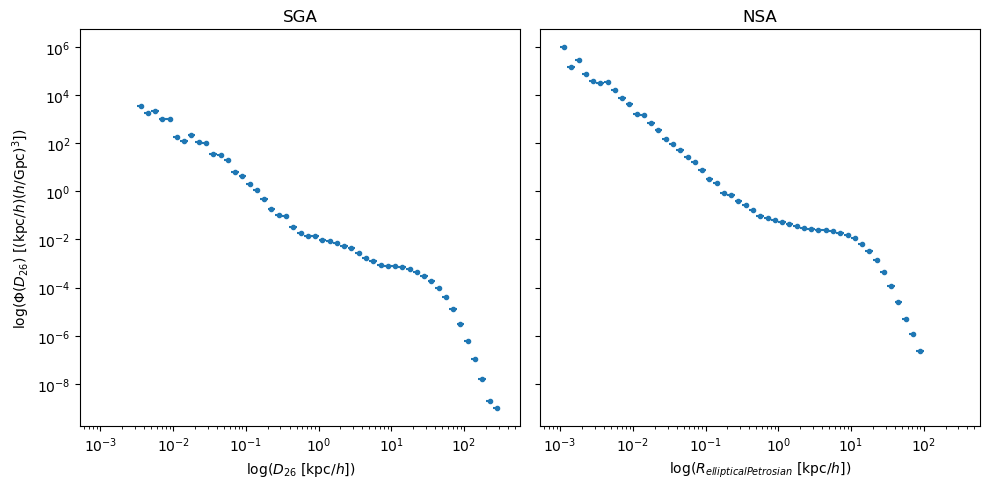

In [7]:
# D26kpc_binwidth = 5
# D26kpc_bins = np.arange(0, 200, D26kpc_binwidth)
D26kpc_bins = np.logspace(-3, 2.5, 56)
D26kpc_binwidth = D26kpc_bins[1:] - D26kpc_bins[:-1]

# ignore NaN values
good = np.isfinite(SGA['DIST_MAX']) & (SGA['DIST_MAX'] > 0)
good_nsa = np.isfinite(NSA['DIST_MAX']) & (NSA['DIST_MAX'] > 0)

size_func, bin_edges = np.histogram(SGA['D26_kpc'][good], 
                                    bins=D26kpc_bins, 
                                    weights=1/SGA['DIST_MAX'][good].to('Mpc').value**3, 
                                    # density=True
                                   )
N, bin_edges = np.histogram(SGA['D26_kpc'][good], 
                            bins=D26kpc_bins)

size_func_nsa, bin_edges = np.histogram(NSA['R_ELPETRO_kpc'][good_nsa], 
                                        bins=D26kpc_bins, 
                                        weights=1/NSA['DIST_MAX'][good_nsa].to('Mpc').value**3
                                       )

fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True, tight_layout=True)

ax = axes[0]
ax.errorbar(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
            size_func, 
            xerr=0.5*D26kpc_binwidth, 
            # yerr=np.sqrt(N), 
            # yerr=np.sqrt(size_func),
            fmt='.')

ax.set(xscale='log', 
       yscale='log', 
       xlabel='log($D_{26}$ [kpc/$h$])', 
       ylabel=r'log($\Phi(D_{26})$ [(kpc/$h$)($h$/Gpc)$^3$])', 
       title='SGA')


ax = axes[1]
ax.errorbar(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
            size_func_nsa, 
            xerr=0.5*D26kpc_binwidth, 
            # yerr=1/np.sqrt(N), 
            # yerr=np.sqrt(size_func_nsa),
            fmt='.')

ax.set(xlabel='log($R_{elliptical Petrosian}$ [kpc/$h$])', 
       title='NSA');

## Parameterize the size function

We'll try a Schechter function first:
\begin{equation}
  dn(R_{26}) = \phi(R_{26}) dR_{26} = \ln 10 \phi^* \left( \frac{R_{26}}{R_{26}^*} \right)^{\alpha + 1} e^{-R_{26}/R_{26}^*} \, d\log R_{26}
\end{equation}

In [8]:
def Schecht_log(x, dlogx, p, a, xs):
    '''
    Compute the Schechter function for quantity x, which is assumed to be in log-space.


    PARAMETERS
    ==========
    x : ndarray of length (N,)
        x-parameter of who's counts are being modeled by the Schechter function.  
        Assumed to be in log-space.
    dlogx : float or ndarray of length (N,)
        bin width of x, in log space
    p : float
        phi^*, the normalization of the Schechter function
    a : float
        alpha, the slope of the faint-end
    xs : float
        "knee" of the Schechter function
    '''
    return np.log(10) * p * (x/xs)**(a + 1) * np.exp(-x/xs) * dlogx


def power_log(x, dlogx, p, a, xs):
    '''
    Compute a power law (with the same form as Schechter, but no exponential 
    cutoff) for quantity x, which is assumed to be in log-space.


    PARAMETERS
    ==========
    x : ndarray of length (N,)
        x-parameter of who's counts are being modeled by the Schechter function.  
        Assumed to be in log-space.
    dlogx : float or ndarray of length (N,)
        bin width of x, in log space
    p : float
        phi^*, the normalization of the Schechter function
    a : float
        alpha, the slope of the faint-end
    xs : float
        "knee" of the Schechter function
    '''
    return np.log(10) * p * (x/xs)**(a + 1) * dlogx


def Schecht(x, dx, p, a, xs):
    '''
    Compute the Schechter function for quantity x, which is assumed to be in linear space.


    PARAMETERS
    ==========
    x : ndarray of length (N,)
        x-parameter of who's counts are being modeled by the Schechter function.
    dx : float or ndarray of length (N,)
        bin width of x, in linear space
    p : float
        phi^*, the normalization of the Schechter function
    a : float
        alpha, the slope of the faint-end
    xs : float
        "knee" of the Schechter function
    '''
    return p * (x/xs)**a * np.exp(-x/xs) * dx / xs


def logL(params, n, x, dx):
    '''
    Log-likelihood

    PARAMETERS
    ==========
    params : list or ndarray
        List of 2xthree parameters: scale factor, slope, and knee
    n : ndarray
        (weighted) binned counts
    x : ndarray
        Bin centers used to construct the histogrammed counts n
    dx : float or ndarray
        Bin width used to construct the histogrammed counts

    RETURNS
    =======
    logL : float
        Log likelihood of set n given model parameters
    '''

    # lambda1 = Schecht_log(x, dx, 10**params[0], params[1], params[2])
    # lambda1 = Schecht_log(x, dx, 10**params[0], params[1], params[2]) + Schecht_log(x, dx, 10**params[3], params[4], params[5])
    lambda1 = Schecht_log(x, dx, 10**params[0], params[1], params[2]) + Schecht_log(x, dx, 10**params[3], params[4], params[5]) + Schecht_log(x, dx, 10**params[6], params[7], params[8])
    # lambda1 = Schecht_log(x, dx, 10**params[0], params[1], params[2]) + Schecht_log(x, dx, 10**params[3], params[4], params[5]) + power_log(x, dx, 10**params[6], params[7], params[8])

    lambda1[lambda1 <= 0] = np.finfo(dtype=np.float64).tiny

    return np.sum(n*np.log(lambda1) - lambda1 - gammaln(n + 1))


def nlogL(params, n, x, dx):
    '''Negative log likelihood, for minimizers'''
    return -logL(params, n, x, dx)

### Fit with `scipy.optimize.minimize`

In [12]:
bounds1 = [[3, 10], [-2, 0], [10, 20]]
bounds2 = [[5, 10], [-2, 0], [1, 5]]
bounds3 = [[10, 15], [-5, 0], [0, 1]]

p0 = [6.8, -0.8, 15, 8, -1, 2, 11, -2.5, 0.07]

bestfit = minimize(nlogL, p0, args=(size_func, bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1), bounds=bounds1 + bounds2 + bounds3)

'''
bestfit = None

for i in range(100):

    p0 = [np.random.uniform(b[0], b[1]) for b in bounds1 + bounds2 + bounds3]
    
    # result = minimize(nlogL, p0, args=(size_func, bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1), bounds=bounds1)
    # result = minimize(nlogL, p0, args=(size_func, bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1), bounds=bounds1 + bounds2)
    result = minimize(nlogL, p0, args=(size_func, bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1), bounds=bounds1 + bounds2 + bounds3)

    if result.success:

        if bestfit is None:
            bestfit = result
        else:
            if result.fun < bestfit.fun:
                bestfit = result
'''
bestfit

/tmp/ipykernel_1270716/51973665.py:20: RuntimeWarning: divide by zero encountered in true_divide
  return np.log(10) * p * (x/xs)**(a + 1) * np.exp(-x/xs) * dlogx
/tmp/ipykernel_1270716/51973665.py:20: RuntimeWarning: invalid value encountered in multiply
  return np.log(10) * p * (x/xs)**(a + 1) * np.exp(-x/xs) * dlogx


      fun: nan
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.62500003e+07, -8.59374996e+07,  0.00000000e+00,  1.61562487e+09,
       -2.78437499e+09,  5.07812503e+07,  8.52526625e+13, -1.33300199e+14,
        8.12477733e+14])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 20
      nit: 0
     njev: 2
   status: 2
  success: False
        x: array([ 6.8 , -0.8 , 15.  ,  8.  , -1.  ,  2.  , 11.  , -2.5 ,  0.07])

/tmp/ipykernel_1270716/2128177551.py:7: RuntimeWarning: divide by zero encountered in true_divide
  yerr=1/np.sqrt(size_func),


AttributeError: 'NoneType' object has no attribute 'x'

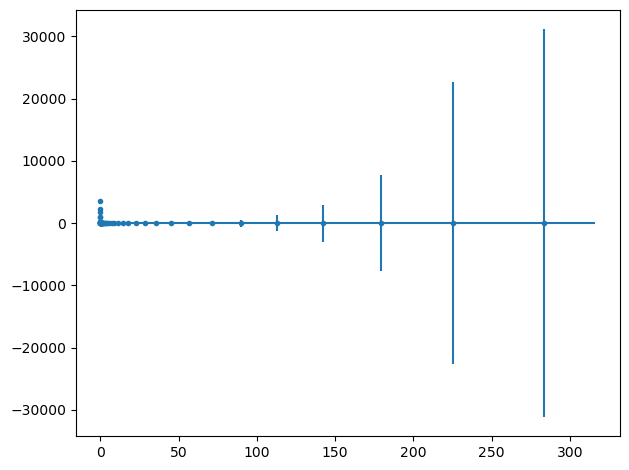

In [10]:
plt.figure(tight_layout=True)

plt.errorbar(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
             size_func, 
             xerr=0.5*D26kpc_binwidth, 
             # yerr=1/np.sqrt(N), 
             yerr=1/np.sqrt(size_func),
             fmt='.')

# Actual fit
plt.plot(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
         # Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**bestfit.x[0], bestfit.x[1], bestfit.x[2]) + Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**bestfit.x[3], bestfit.x[4], bestfit.x[5]) + Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**bestfit.x[6], bestfit.x[7], bestfit.x[8]),
         Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**bestfit.x[0], bestfit.x[1], bestfit.x[2]) + Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**bestfit.x[3], bestfit.x[4], bestfit.x[5]) + power_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**bestfit.x[6], bestfit.x[7], bestfit.x[8]),
         c='tab:red'
        )
plt.plot(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
         Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**bestfit.x[0], bestfit.x[1], bestfit.x[2]),
         ':', c='tab:red'
        )
plt.plot(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
         Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**bestfit.x[3], bestfit.x[4], bestfit.x[5]),
         ':', c='tab:red'
        )
plt.plot(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
         # Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**bestfit.x[6], bestfit.x[7], bestfit.x[8]),
         power_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**bestfit.x[6], bestfit.x[7], bestfit.x[8]),
         ':', c='tab:red'
        )

# Manual fit
plt.plot(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
         Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**6.8, -0.8, 15) + Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**8, -1, 2) + Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**11, -2.5, 0.07)
        )
plt.plot(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
         Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**6.8, -0.8, 15), # phi_* = 10**6
         ':', c='tab:orange'
        )
plt.plot(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
         Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**8, -1, 2), # phi_* = 10**7
         ':', c='tab:orange'
        )
plt.plot(bin_edges[:-1] + 0.5*D26kpc_binwidth, 
         Schecht_log(bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1, 10**11, -2.5, 0.07), # phi_* = 10**7
         ':', c='tab:orange'
        )

plt.xscale('log')
plt.yscale('log')

plt.ylim([10**-2, 10**14])

plt.grid(ls=':')

# plt.xlabel('$D_{26}$ [kpc/$h$]')
plt.xlabel('log($D_{26}$ [kpc/$h$])')
plt.ylabel(r'log($\phi(D_{26})$ [($h$/Gpc)$^3$])');

### Fit with MCMC

In [79]:
def log_prior(theta):
    
    p1, a1, xs1, p2, a2, xs2, p3, a3, xs3 = theta

    if (3 <= p1 <= 10) and (-2 <= a1 <= 0) and (10 <= xs1 <= 20) and (5 <= p2 <= 10) and (-2 <= a2 <= 0) and (0 <= xs2 <= 5) and (8 <= p3 <= 15) and (-5 <= a3 <= -2) and (0 <= xs3 <= 1):
        return 0.0
    return -np.inf


def log_probability(theta, n, x, dx):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + logL(theta, n, x, dx)

In [84]:
pos = np.array([6.8, -0.8, 15, 8, -1, 2, 11, -2.5, 0.07]) + 0.01*np.random.randn(32, 9)
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, 
                                ndim, 
                                log_probability, 
                                args=(size_func, bin_edges[:-1] + 0.5*D26kpc_binwidth, 0.1)
                               )
sampler.run_mcmc(pos, 8000, progress=True);

100%|██████████| 8000/8000 [00:18<00:00, 422.68it/s]


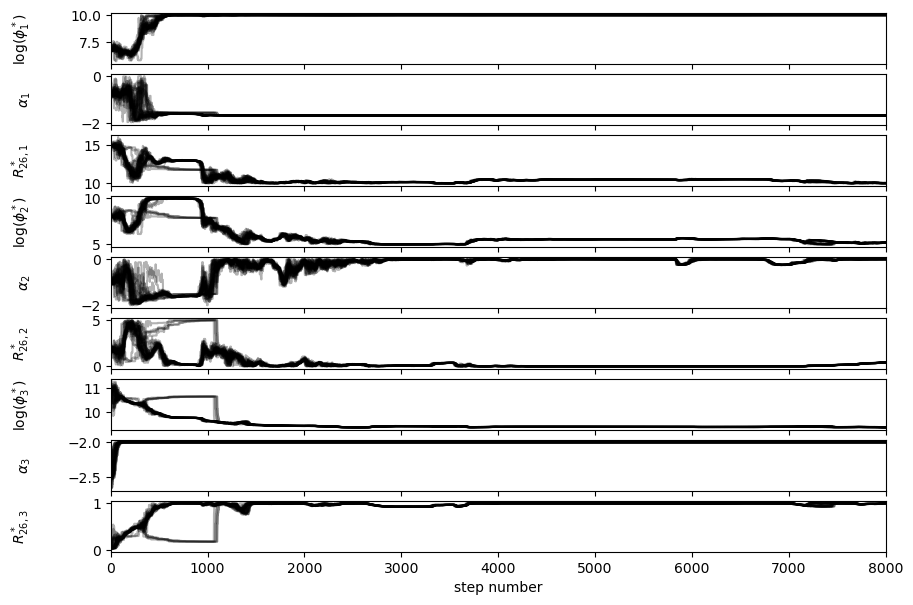

In [85]:
fig, axes = plt.subplots(9, figsize=(10, 7), sharex=True)

samples = sampler.get_chain()

labels = [r"log($\phi_1^*$)", r"$\alpha_1$", "$R_{26,1}^*$", r"log($\phi_2^*$)", r"$\alpha_2$", "$R_{26,2}^*$", r"log($\phi_3^*$)", r"$\alpha_3$", "$R_{26,3}^*$"]

for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [35]:
flat_samples = sampler.get_chain(discard=3000, thin=15, flat=True)
print(flat_samples.shape)

(8512, 9)


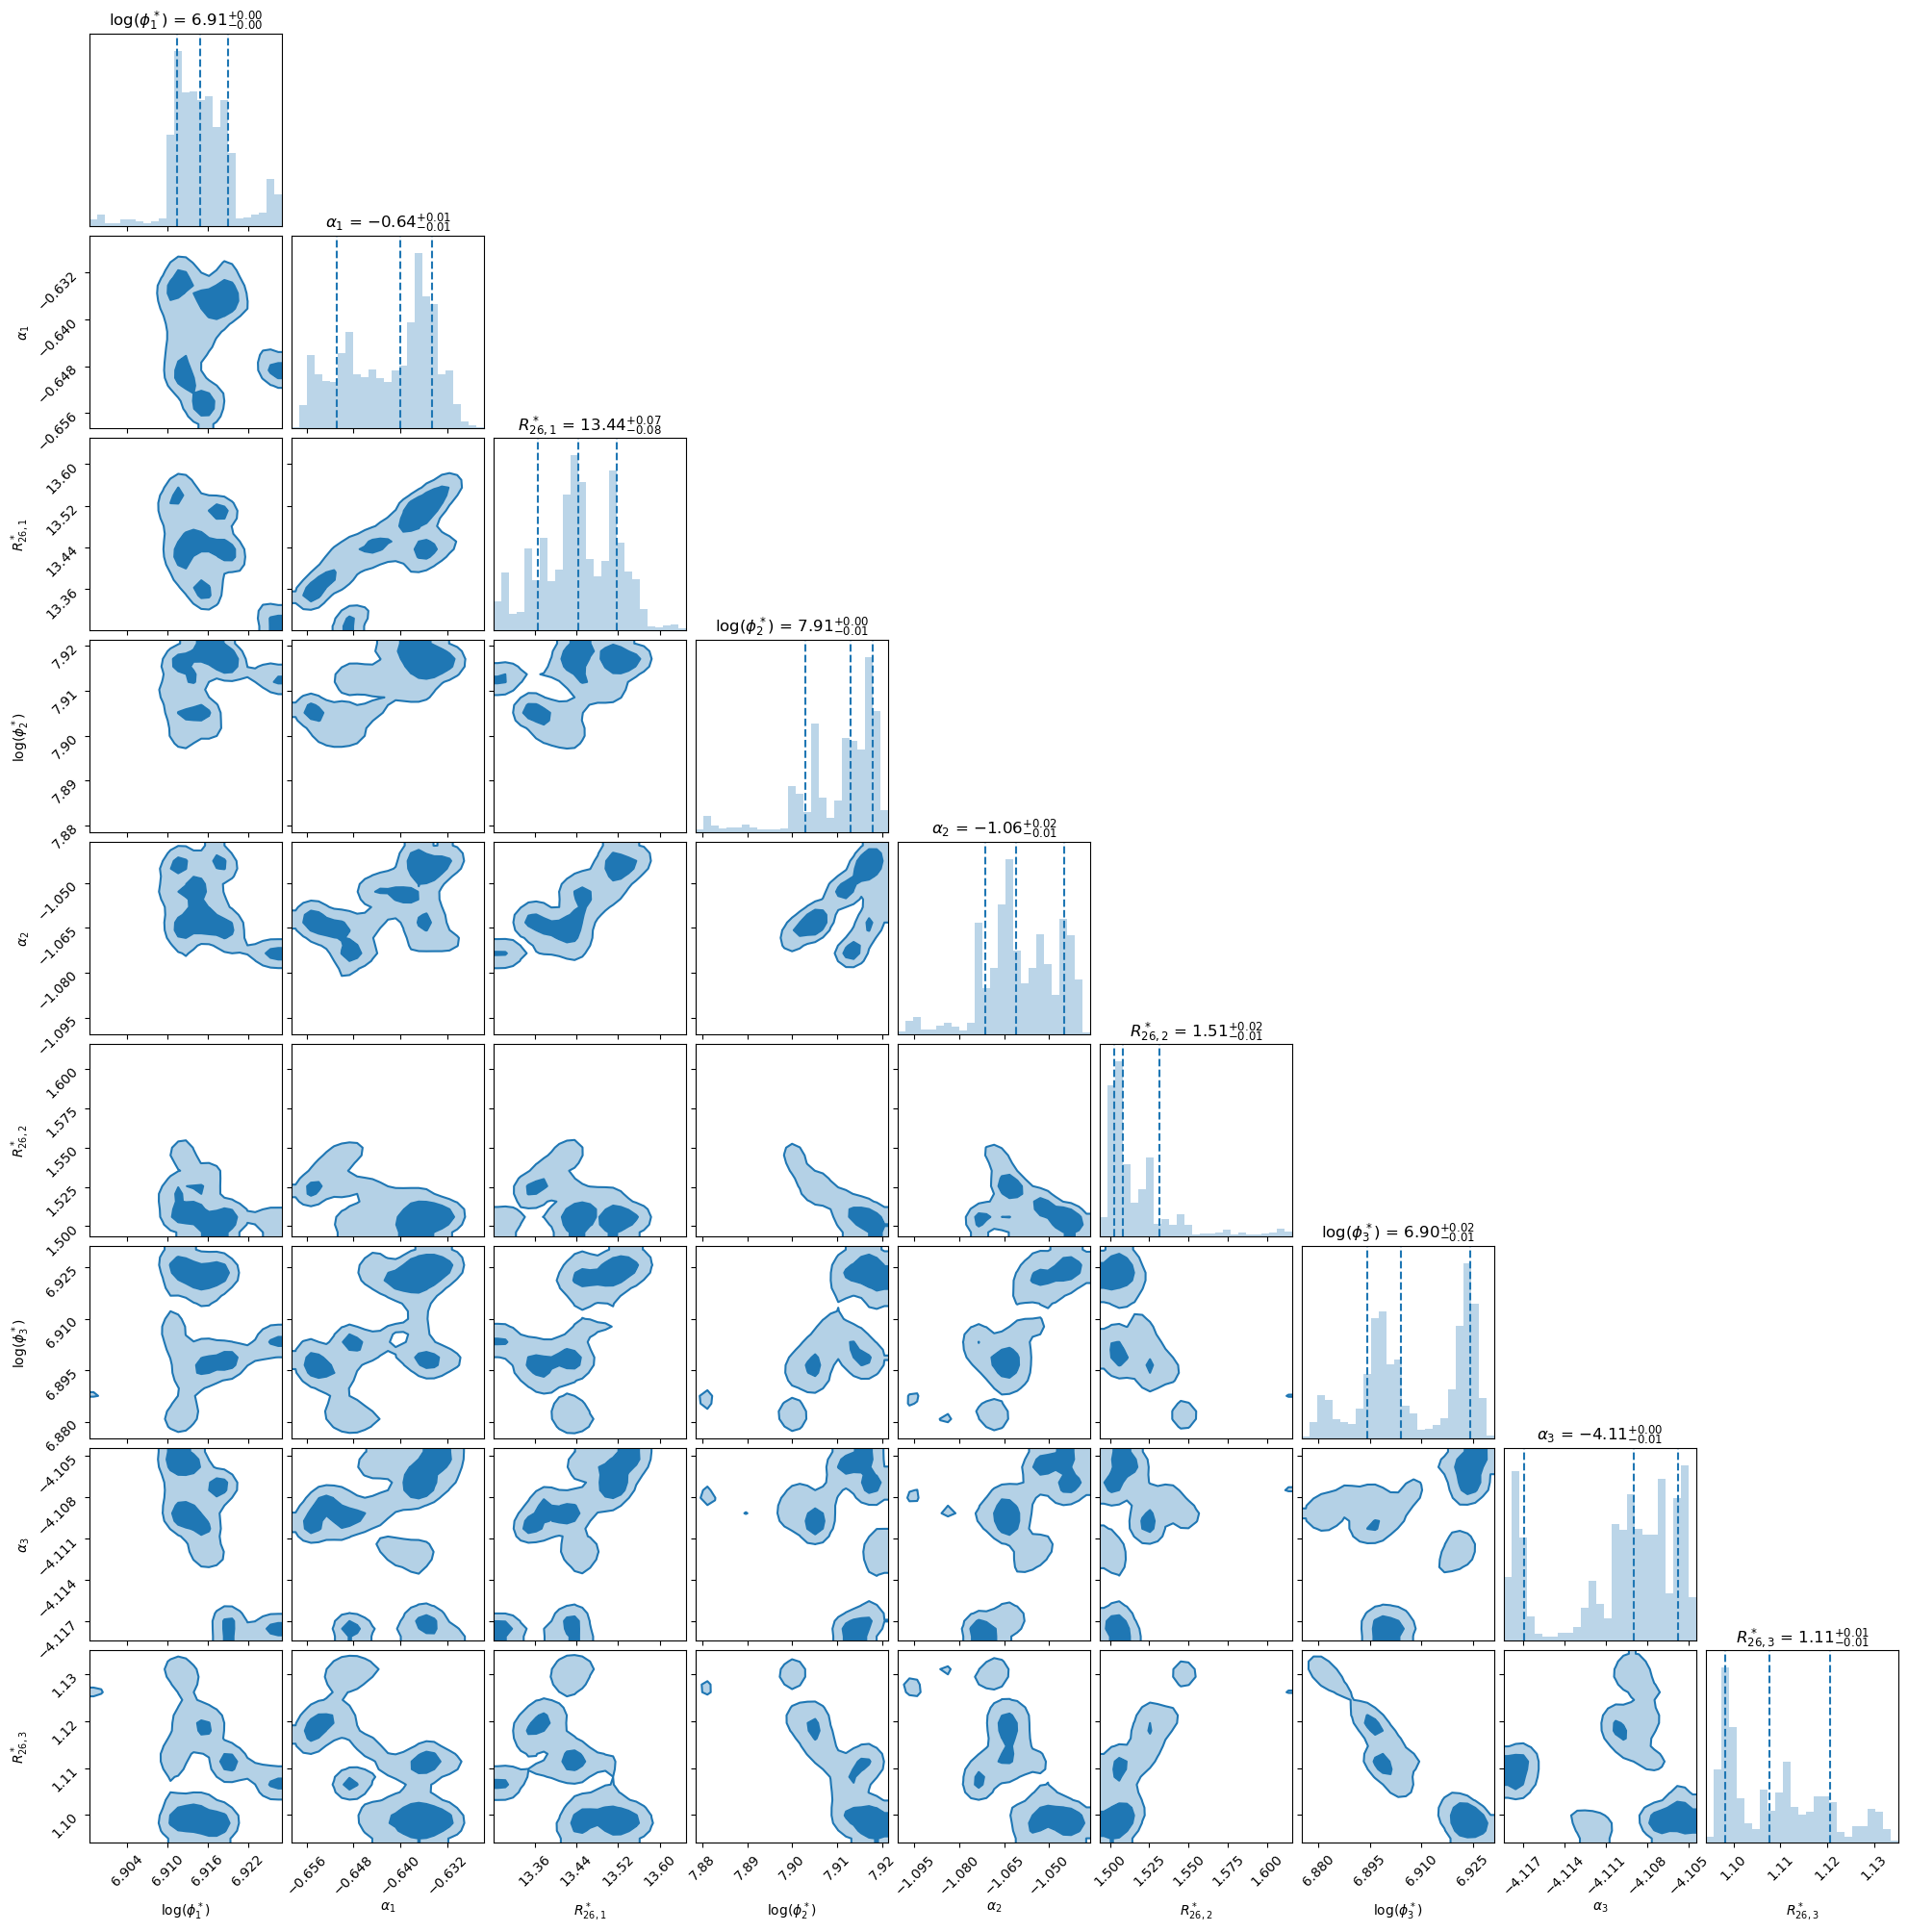

In [36]:
fig = corner(flat_samples, bins=25, smooth=1,
             labels=labels, 
             levels=(1 - np.exp(-0.5), 1 - np.exp(-2)), 
             quantiles=[0.16, 0.5, 0.84], 
             color='tab:blue', 
             hist_kwargs={'histtype':'stepfilled', 'alpha':0.3}, 
             plot_datapoints=False,
             fill_contours=True, 
             show_titles=True);